# MCMC Bayesian A/B Testing

In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/kazutak/Git/AB_test/.venv/bin/python
3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.util import initialize_model

PyMC やりたい場合はあきらめて [Colabo](https://colab.research.google.com/drive/1vkHr3EQGtwwJJ6haHVxsxNglkuXv_XX6) へ<br>
poetry で pymc 環境を入れようとすると、コンパイル系でエラーがよく出るらしい<br>
conda 使えっていう助言あり、仕事で展開むずそうなので、一旦 Colab での実装を想定してすすめる 2023/10/07<br>
+ https://stackoverflow.com/questions/76927920/installing-pymc-with-poetry-compileerror
+ https://discourse.pymc.io/t/pytensor-import-error-mac-m1/12711

In [3]:
from jax import random
A = dist.Normal(50, 5).sample(random.PRNGKey(2), (10,))
B = dist.Normal(55, 5).sample(random.PRNGKey(1), (10,))

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/220876885.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(A)
/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/220876885.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(B)


<Axes: ylabel='Density'>

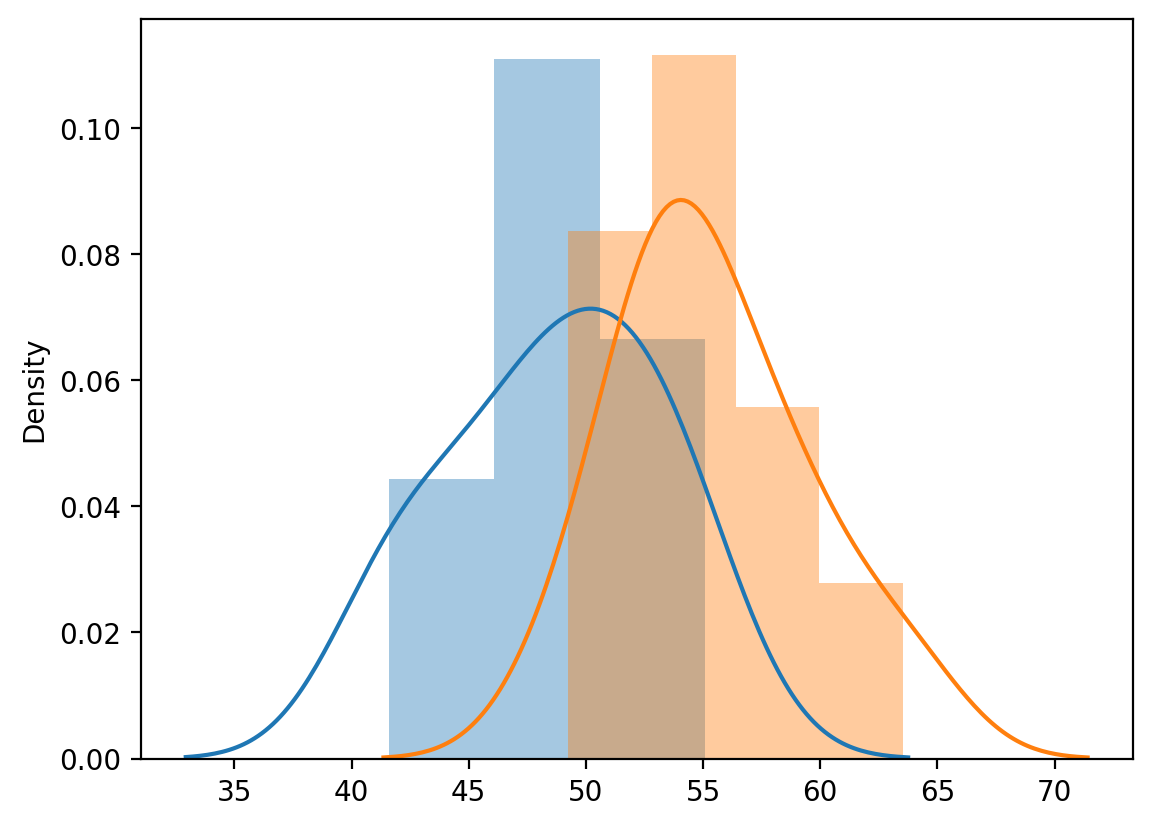

In [4]:
sns.distplot(A)
sns.distplot(B)

In [5]:
def model_normal(x):
    mu = numpyro.sample("mu", dist.Normal(52, 5))
    scale = numpyro.sample("scale", dist.LogNormal(1))
    with numpyro.plate("N", len(x)):
        numpyro.sample("obs", dist.Normal(mu, scale), obs=x)

In [6]:
# 乱数の固定に必要
rng_key= random.PRNGKey(0)

# NUTSでMCMCを実行する
kernel = NUTS(model_normal)
mcmcA = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, thinning=1)
mcmcA.run(
    rng_key=rng_key,
    x=A
)
samplesA = mcmcA.get_samples()
mcmcA.print_summary()


/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/4055533552.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmcA = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, thinning=1)
sample: 100%|█| 3000/3000 [00:01<00:00, 2535.12it/s, 3 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9718.93it/s, 7 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9508.97it/s, 7 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9587.67it/s, 1 steps o



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     48.94      1.47     48.91     46.50     51.27   4122.14      1.00
     scale      4.77      1.18      4.56      3.02      6.46   3948.31      1.00

Number of divergences: 0


In [7]:
# 乱数の固定に必要
rng_key= random.PRNGKey(0)

# NUTSでMCMCを実行する
kernel = NUTS(model_normal)
mcmcB = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, thinning=1)
mcmcB.run(
    rng_key=rng_key,
    x=B
)
samplesB = mcmcB.get_samples()
mcmcB.print_summary()


/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/4216811859.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmcB = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, thinning=1)
sample: 100%|█| 3000/3000 [00:01<00:00, 2652.44it/s, 3 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9255.66it/s, 7 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9661.89it/s, 3 steps o
sample: 100%|█| 3000/3000 [00:00<00:00, 9770.65it/s, 3 steps o


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     55.20      1.35     55.21     52.91     57.31   4204.37      1.00
     scale      4.35      1.07      4.17      2.72      5.87   3833.45      1.00

Number of divergences: 0


In [8]:
def model_diff():
    mu_A = numpyro.sample("mu_A", dist.Normal(52, 5))
    scale_A = numpyro.sample("scale_A", dist.LogNormal(1))
    mu_B = numpyro.sample("mu_B", dist.Normal(52, 5))
    scale_B = numpyro.sample("scale_B", dist.LogNormal(1))

    normal_A = numpyro.sample("normal_A", dist.Normal(mu_A, scale_A))
    normal_B = numpyro.sample("normal_B", dist.Normal(mu_B, scale_B))
    
    diff = numpyro.deterministic("diff", (normal_B - normal_A)/normal_B)

In [9]:
samples = {}
samples["mu_A"] = samplesA["mu"]
samples["scale_A"] = samplesA["scale"]
samples["mu_B"] = samplesB["mu"]
samples["scale_B"] = samplesB["scale"]

In [10]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_diff, samples)
predictions = predictive(rng_key_)
predictions.keys()

dict_keys(['diff', 'normal_A', 'normal_B'])

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/2890173946.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions["normal_A"], label="A")
/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_53125/2890173946.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred

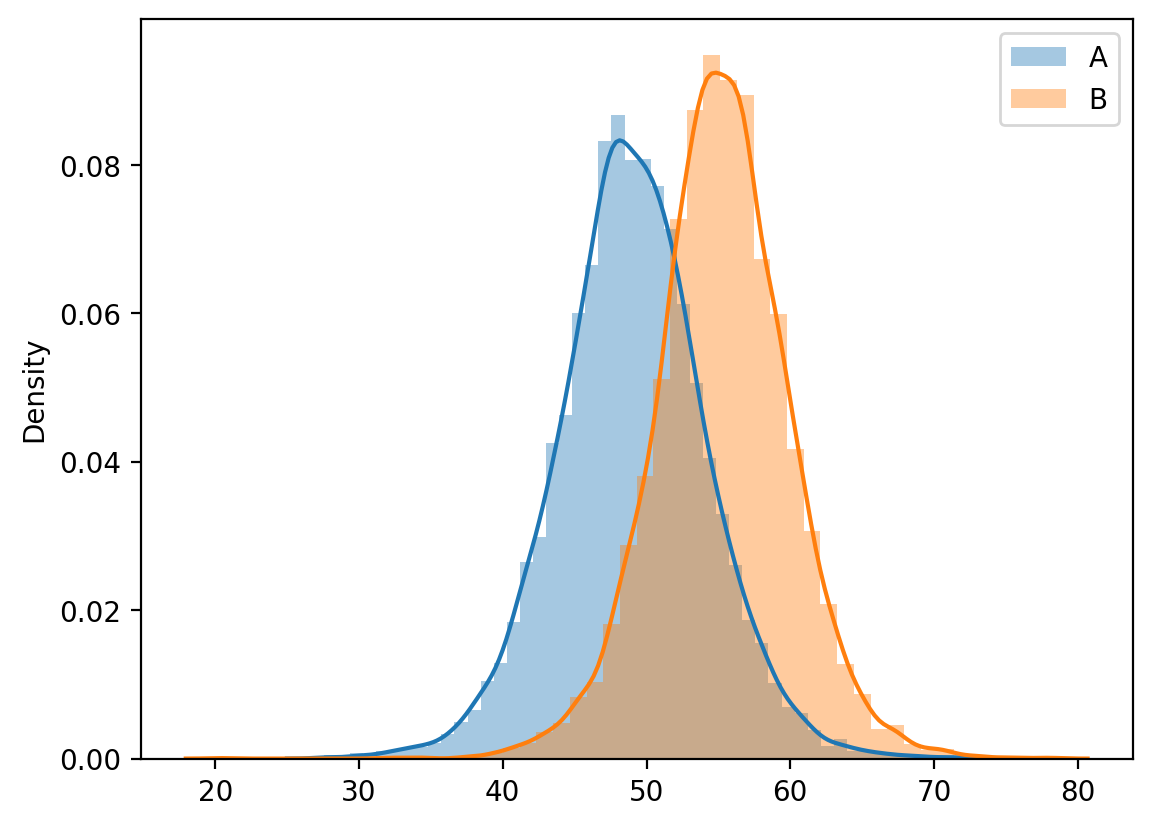

In [12]:
sns.distplot(predictions["normal_A"], label="A")
sns.distplot(predictions["normal_B"], label="B")
plt.legend()
plt.show()